# Subtask2a

In [140]:
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report

class DataGenerator(Sequence):
    def __init__(self, data, batch_size, clip_processor, clip_model, data_type, label_binarizer, max_length=77, is_training=True, is_labeled=True):
        self.data = data
        self.batch_size = batch_size
        self.clip_processor = clip_processor
        self.clip_model = clip_model
        self.label_binarizer = label_binarizer
        self.max_length = max_length
        self.indices = np.arange(len(self.data))
        self.is_training = is_training  # New attribute to indicate training mode
        self.is_labeled = is_labeled  # New flag to indicate if data is labeled
        self.image_dir = data_paths[data_type]['image_dir']  # Get image directory based on data_type


    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.data[k] for k in batch_indices]
        
        if self.is_labeled:
            X, y = self.preprocess_data(batch)
            if self.is_training:
                return X, y
            else:
                batch_ids = [sample["id"] for sample in batch]
                return X, y, batch_ids
        else:
            X = self.preprocess_data(batch, labeled=False)
            if not self.is_training:
                batch_ids = [sample["id"] for sample in batch]
            return X, batch_ids 

    def load_image(self, image_path):
        try:
            with Image.open(image_path) as img:
                return img.convert('RGB')
        except IOError:
            print(f"Error in loading image: {image_path}. Using a placeholder image.")
            return Image.new('RGB', (224, 224), color='white')

    def preprocess_data(self, batch, labeled=True):
        texts = [sample["text"] for sample in batch]
        image_filenames = [sample["image"] for sample in batch]
        if labeled and self.label_binarizer:
            labels = [sample.get("labels", []) for sample in batch]
            default_label = ['None']
            labels = [label if label else default_label for label in labels]
            y = self.label_binarizer.transform(labels)
        else:
            y = None
        processed_texts = self.clip_processor(text=[text[:self.max_length] for text in texts], return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.clip_model.device) for k, v in processed_texts.items()}
        text_embeddings = self.clip_model.get_text_features(**inputs).cpu().detach().numpy()

        images = [self.load_image(os.path.join(self.image_dir, filename)) for filename in image_filenames]
        processed_images = self.clip_processor(images=images, return_tensors="pt")
        image_embeddings = self.clip_model.get_image_features(**processed_images).cpu().detach().numpy()
        combined_embeddings = np.concatenate((text_embeddings, image_embeddings), axis=1)
        
        if labeled:
            return combined_embeddings, y
        else:
            return combined_embeddings

    def on_epoch_end(self):
        np.random.shuffle(self.indices) 
    
class MultiMemeClassification:
    def __init__(self, label_tree, data_paths):
        self.label_tree = label_tree
        self.label_binarizer = MultiLabelBinarizer()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.model = None
        self.data_paths = data_paths  #dictionary for data paths by type

    def load_and_preprocess_data(self, data_type, sample_size=None):
        #select the file and image paths based on the data_type
        data_info = self.data_paths.get(data_type)
        if not data_info:
            raise ValueError(f"Invalid data type: {data_type}")

        json_file_path = data_info.get('json_path')
        image_dir = data_info.get('image_dir')

        # load JSON data
        with open(json_file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        #check if image files exist
        for sample in data:
            image_path = os.path.join(image_dir, sample.get("image", ""))
            if not os.path.exists(image_path):
                print(f"Warning: Image file not found at {image_path}")

        if sample_size:
            data = np.random.choice(data, sample_size, replace=False)

        #handling labels differently based on data_type
        if data_type == 'test':
            #for 'test' data, labels may not be present
            labels = [sample.get("labels", None) for sample in data]
            #keep only samples with labels (filter out None)
            labels = [label for label in labels if label is not None]
        else:
            #for 'train' and 'dev' data, assign a default label if none exist
            default_label = ['None']
            labels = [sample.get("labels", []) for sample in data]
            labels = [label if label else default_label for label in labels]

        self.label_binarizer.fit(labels)

        return data

    
    def explore_data(self, sample_size=None, data_type='train', examples_to_show=2):
        data = self.load_and_preprocess_data(data_type, sample_size)

        print(f"Total number of samples: {len(data)}")
        print(f"Total number of unique labels: {len(self.label_binarizer.classes_)}")
        print("Unique labels:", self.label_binarizer.classes_)

        data_generator = DataGenerator(data, batch_size=1, clip_processor=self.clip_processor, clip_model=self.clip_model, label_binarizer=self.label_binarizer, data_type=data_type)

        for i in range(examples_to_show):
            sample = [data[i]]  # Wrap the single sample in a list
            combined_embeddings, _ = data_generator.preprocess_data(sample, labeled=True)

            print(f"\nSample {i+1}:")
            print("Text:", sample[0]["text"])
            print("Image:", sample[0]["image"])
            print("Combined Embedding Shape:", combined_embeddings.shape)
            print("Combined Embedding:", combined_embeddings)
            
    def build_model(self, num_classes, embedding_size=1024):
        input_layer = Input(shape=(embedding_size,), dtype='float32', name="input")
        dense_layer = Dense(1024, activation='relu')(input_layer)
        output_layer = Dense(num_classes, activation='sigmoid')(dense_layer)

        self.model = Model(inputs=input_layer, outputs=output_layer)
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return self.model

    
    def train_model(self, save_model_path, batch_size=32, epochs=5, data_type='train', validation_size=0.2, random_state=42, sample_size=None):
        data = self.load_and_preprocess_data(data_type, sample_size)

        #split data into training and validation sets
        X_train_indices, X_val_indices = train_test_split(
            range(len(data)), test_size=validation_size, random_state=random_state
        )

        #generate training and validation data using indices
        train_data = [data[i] for i in X_train_indices]
        val_data = [data[i] for i in X_val_indices]

        #initialize data generators
        train_generator = DataGenerator(train_data, batch_size, self.clip_processor, self.clip_model, self.label_binarizer, is_training=True, data_type=data_type,)
        val_generator = DataGenerator(val_data, batch_size, self.clip_processor, self.clip_model, self.label_binarizer, is_training=True, data_type=data_type,)

        #build and train the model
        self.build_model(num_classes=len(self.label_binarizer.classes_))
        history = self.model.fit(
            train_generator, epochs=epochs, validation_data=val_generator
        )

        #save model
        self.model.save_weights(save_model_path)
        print(f"Model saved at {save_model_path}")

        return history
   
    def plot_training_history(self, history):
        plt.figure(figsize=(10, 4))
        
        #plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        #plot loss 
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.show()      

    def calculate_hierarchy_distance(self, node1, node2):
        def find_path(tree, node, path=[]):
            if node in tree:
                return path + [node]
            for k, v in tree.items():
                if isinstance(v, dict):
                    new_path = find_path(v, node, path + [k])
                    if new_path:
                        return new_path
            return []

        node1_tuple = (node1,) if isinstance(node1, str) else node1
        node2_tuple = (node2,) if isinstance(node2, str) else node2

        path1 = find_path(self.label_tree, node1_tuple)
        path2 = find_path(self.label_tree, node2_tuple)

        common_length = len(set(path1) & set(path2))
        distance = len(path1) + len(path2) - 2 * common_length
        return distance
    

    def evaluate_model(self, batch_size, save_model_path, num_classes, output_json_path, data_type='dev'):
        # Load and preprocess test data
        dev_data = self.load_and_preprocess_data(data_type)
        test_generator = DataGenerator(dev_data, batch_size, self.clip_processor, self.clip_model, self.label_binarizer, data_type=data_type, is_training=False)

        # Build the model and load saved weights
        self.build_model(num_classes=num_classes)
        self.model.load_weights(save_model_path)

        #initialize variables for metrics calculation
        total_precision = 0
        total_recall = 0
        total_samples = 0
        true_labels_all = []
        predicted_labels_all = []

        #initialize MultiLabelBinarizer
        mlb = MultiLabelBinarizer(classes=self.label_binarizer.classes_)
        mlb.fit([self.label_binarizer.classes_])

        results = []  # List to store results

        #iterate over batches in the test generator
        for X, y_true, batch_ids in test_generator:
            y_pred = self.model.predict(X)

            #iterate over predictions in the batch
            for sample_id, prediction, true_label in zip(batch_ids, y_pred, y_true):
                gold_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if true_label[j] == 1]
                predicted_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if prediction[j] > 0.5]
                prediction_list = prediction.tolist()

                label_probabilities = {label: float(prob) for label, prob in zip(self.label_binarizer.classes_, prediction_list)}

                true_labels_all.append(gold_labels)
                predicted_labels_all.append(predicted_labels)

                results.append({
                    'id': sample_id,
                    'ture_labels': gold_labels,
                    'predicted_labels': predicted_labels,
                    'predicted_probabilities': label_probabilities  # Convert numpy array to list
                    
                })
                
                #hierarchical evaluation
                for predicted_label in predicted_labels:
                    if predicted_label in gold_labels:
                        total_precision += 1
                        total_recall += 1
                    else:
                        for gold_label in gold_labels:
                            distance = self.calculate_hierarchy_distance(predicted_label, gold_label)
                            if distance is not None and distance > 0:
                                total_precision += 0.5
                                total_recall += 0.5

                total_samples += 1

        #aggregate metrics over all samples
        average_precision = total_precision / total_samples if total_samples > 0 else 0
        average_recall = total_recall / total_samples if total_samples > 0 else 0
        hierarchical_f1 = 2 * (average_precision * average_recall) / (average_precision + average_recall) if (average_precision + average_recall) != 0 else 0

        true_labels_all_binary = mlb.transform(true_labels_all)
        predicted_labels_all_binary = mlb.transform(predicted_labels_all)
        target_names = self.label_binarizer.classes_
        
        print("Classification Report:")
        print(classification_report(true_labels_all_binary, predicted_labels_all_binary, target_names=target_names))
        
        result_file_name = f"subtask2a_dev_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(results, json_file, indent=4)
            
        return hierarchical_f1
       
    def test_model(self, batch_size, save_model_path, output_json_path, data_type='test'):
    
        test_data = self.load_and_preprocess_data(data_type)

        test_generator = DataGenerator(test_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=False, is_labeled=False)

        #load the trained model weights
        self.build_model(num_classes=num_classes)
        self.model.load_weights(save_model_path)

        predictions = []

        #generate predictions
        for X, batch_ids in test_generator:
            y_pred = self.model.predict(X)
            for sample_id, prediction in zip(batch_ids, y_pred):
                predicted_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if prediction[j] > 0.1]
                prediction_list = prediction.tolist()
                
                label_probabilities = {label: float(prob) for label, prob in zip(self.label_binarizer.classes_, prediction_list)}
                predictions.append({
                    'id': sample_id,
                    'predicted_labels': predicted_labels,
                    'predicted_probabilities': label_probabilities  # Convert numpy array to list
                    
                })
        result_file_name = f"subtask2a_test_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(predictions, json_file, indent=4)
            
        return "Predictions completed."

#hierarchical tree
#the assigned number are hypothetically
label_tree = {
    'Persuasion': {
        'Pathos': {
            'Appeal to Emotion(visual)': 1,
            'Exaggeration/Minimisation': 2,
            'Loaded Language': 3,
            'Flag waving': 4,
            'Appeal to fear/prejudice': 5,
            'Transfer': 6
        },
        'Ethos': {
            'Transfer': 6,
            'Glittering generalities': 7,
            'Appeal to authority': 8,
            'Bandwagon': 9,
            'Ad Hominem': {
                'Name calling/Labelling': 10,
                'Doubt': 11,
                'Smears': 12,
                'Reduction and Hitlerium': 13,
                'Whataboutism': 14
            }
        },
        'Logos': {
            'Repetition': 15,
            'Obfuscation, Intentional vagueness, Confusion': 16,
            'Justification': {
                'Flag waving': 4,
                'Appeal to fear/prejudice': 5,
                'Appeal to Authority': 8,
                'Bandwagon': 9,
                'Slogans': 17
            },
            'Reasoning': {
                'Distraction': {
                    'Whataboutism': 14,
                    'Presenting Irrelevant Data (Red Herring)': 18,
                    'Straw Man': 19
                },
                'Simplification': {
                    'Black-and-white Fallacy/Dictatorship': 20,
                    'Casual Oversimplification': 21,
                    'Thought-terminating cliché': 22
                }
            }
        },
        'None': 23 # a label for empty samples
    }
}

batch_size = 64
num_classes = 23
output_json_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels'
save_model_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/CLIP_model_weights'

data_paths = {
    'train': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/merged_file.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/merged_images'

    },
    'dev': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels/dev_subtask2a_en.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/subtask2a_images/dev_images'
    },
    'test': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/test_data/english/en_subtask2a_test_unlabeled.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/test_data/test_images/subtask1_2a/english'
    }
}

CLIP_meme_classifier2a = MultiMemeClassification(label_tree, data_paths)


In [141]:
#explore the data
CLIP_meme_classifier2a.explore_data(data_type='test', 
                                    examples_to_show=2
                                   )

Total number of samples: 1500
Total number of unique labels: 0
Unique labels: []

Sample 1:
Text: Nicola Sturgeon\n\nWE'RE SCOTTISH GETUSOUTOFHERE!\n\nWill his bushtucker trial involve skydiving into the jungle without the appropriate PPE
Image: prop_meme_8883.png
Combined Embedding Shape: (1, 1024)
Combined Embedding: [[-0.06926914 -0.11997254  0.20920005 ... -0.2838593  -0.21654572
  -0.53922814]]

Sample 2:
Text: I saw a movie once where only the police and military had guns.\n\nIt was called Schindler's List.
Image: prop_meme_10818.png
Combined Embedding Shape: (1, 1024)
Combined Embedding: [[-0.02831829 -0.07093073 -0.02956717 ... -0.27905762  0.06650389
   0.54175067]]


In [83]:
history= CLIP_meme_classifier2a.train_model(save_model_path, 
                                          batch_size=32, 
                                          epochs=5,
                                          data_type='train'
                                         )


Epoch 1/5
188/188 [==============================] - 495s 3s/step - loss: 0.2328 - accuracy: 0.3142 - val_loss: 0.2134 - val_accuracy: 0.3593
Epoch 2/5
188/188 [==============================] - 482s 3s/step - loss: 0.1854 - accuracy: 0.3797 - val_loss: 0.2134 - val_accuracy: 0.3533
Epoch 3/5
188/188 [==============================] - 467s 2s/step - loss: 0.1604 - accuracy: 0.4213 - val_loss: 0.2175 - val_accuracy: 0.3487
Epoch 4/5
188/188 [==============================] - 465s 2s/step - loss: 0.1332 - accuracy: 0.4675 - val_loss: 0.2268 - val_accuracy: 0.3567
Epoch 5/5
188/188 [==============================] - 469s 3s/step - loss: 0.1036 - accuracy: 0.5072 - val_loss: 0.2369 - val_accuracy: 0.3540
Model saved at /Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/CLIP_model_weights


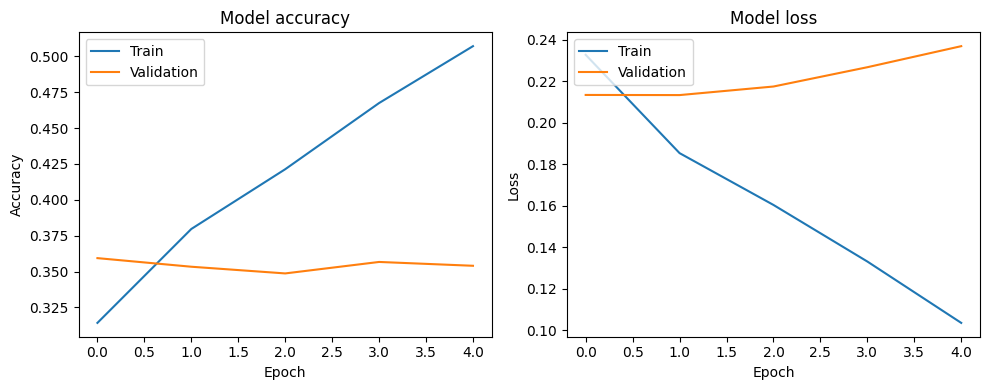

In [85]:
#plot the training history
CLIP_meme_classifier2a.plot_training_history(history)

In [95]:
#evaluate the model using the dev data
hierarchical_f1 = CLIP_meme_classifier2a.evaluate_model(batch_size, 
                                                      save_model_path, 
                                                      num_classes, 
                                                      output_json_path, 
                                                      data_type='dev'
                                                     )
print(f"Average Hierarchical F1: {hierarchical_f1}")


2/2 [==============================] - 0s 3ms/step
Classification Report:
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.59      0.29      0.39        56
                                Appeal to authority       0.75      0.79      0.77       143
                           Appeal to fear/prejudice       0.42      0.06      0.11        78
                                          Bandwagon       0.50      0.06      0.10        18
               Black-and-white Fallacy/Dictatorship       0.49      0.17      0.26       103
                          Causal Oversimplification       0.33      0.02      0.03        56
                                              Doubt       0.17      0.02      0.03        52
                          Exaggeration/Minimisation       0.35      0.09      0.14        68
                                        Flag-waving       0.59      0.53      0.56      

/Users/jamessmith/Desktop/Desktop/python/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jamessmith/Desktop/Desktop/python/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [133]:
#get predictions on the unlabeled test data
CLIP_meme_classifier2a.test_model(batch_size, 
                                save_model_path, 
                                output_json_path,
                                data_type='test'
                               )

1/1 [==============================] - 0s 21ms/step


'Predictions completed.'

In [116]:
node1 = 'Repetition'
node2 = 'Whataboutism'
distance = CLIP_meme_classifier.calculate_hierarchy_distance(node1, node2)
print(f"hierarchical distance between '{node1}' and '{node2}' is: {distance}")



hierarchical distance between 'Repetition' and 'Whataboutism' is: None


# Subtask2b

In [352]:
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelBinarizer
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

class DataGenerator(Sequence):
    def __init__(self, data, batch_size, clip_processor, clip_model, data_type, label_binarizer, max_length=77, is_training=True, labeled=True):
        self.data = data
        self.batch_size = batch_size
        self.clip_processor = clip_processor
        self.clip_model = clip_model
        self.label_binarizer = label_binarizer
        self.max_length = max_length
        self.indices = np.arange(len(self.data))
        self.is_training = is_training  
        self.labeled = labeled  
        self.image_dir = data_paths[data_type]['image_dir']

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.data[k] for k in batch_indices]

        if self.labeled:
            X, y = self.preprocess_data(batch)
            if self.is_training:
                return X, y
            else:
                batch_ids = [sample["id"] for sample in batch]
                return X, y, batch_ids
        else:
            X = self.preprocess_data(batch, labeled=False)
            if not self.is_training:
                batch_ids = [sample["id"] for sample in batch]
            return X, batch_ids
      

    def load_image(self, image_path):
        try:
            with Image.open(image_path) as img:
                return img.convert('RGB')
        except IOError:
            print(f"Error in loading image: {image_path}. Using a placeholder image.")
            return Image.new('RGB', (224, 224), color='white')
        
    def preprocess_data(self, batch, labeled=True):
        texts = [sample["text"] for sample in batch]
        image_filenames = [sample["image"] for sample in batch]
        
        if labeled:
            labels = [sample["label"] for sample in batch]
            y = self.label_binarizer.transform(labels)
        else:
            y = []
            
        processed_texts = self.clip_processor(text=[text[:self.max_length] for text in texts], return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.clip_model.device) for k, v in processed_texts.items()}
        text_embeddings = self.clip_model.get_text_features(**inputs).cpu().detach().numpy()

        images = [self.load_image(os.path.join(self.image_dir, filename)) for filename in image_filenames]
        processed_images = self.clip_processor(images=images, return_tensors="pt")
        image_embeddings = self.clip_model.get_image_features(**processed_images).cpu().detach().numpy()
        combined_embeddings = np.concatenate((text_embeddings, image_embeddings), axis=1)
        
        if labeled:
            return combined_embeddings, y
        else:
            return combined_embeddings

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

class BinaryMemeClassification:       
    def __init__(self, data_paths):
        self.label_binarizer = LabelBinarizer()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.model = None
        self.data_paths = data_paths 
        
        
    def load_and_preprocess_data(self, data_type, sample_size=None):
        #select the file and image paths based on the data_type
        data_info = self.data_paths.get(data_type)
        if not data_info:
            raise ValueError(f"Invalid data type: {data_type}")

        json_file_path = data_info.get('json_path')
        image_dir = data_info.get('image_dir')

        #load JSON data
        with open(json_file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        if sample_size:
            data = np.random.choice(data, sample_size, replace=False)

        #handling labels differently based on data_type
        if data_type in ['train', 'dev']:
            labels = [sample.get("label") for sample in data]
            self.label_binarizer.fit(labels)
        else:
            labels = []

        return data
            
    def explore_data(self, sample_size=None, data_type='train', labeled=True, examples_to_show=2):
        data = self.load_and_preprocess_data(data_type, sample_size)

        print(f"Total number of samples: {len(data)}")
        unique_labels = set(sample.get("label") for sample in data)
        print(f"Total number of unique labels: {len(unique_labels)}")
        print("Unique labels:", unique_labels)
        
        data_generator = DataGenerator(data, batch_size=1, clip_processor=self.clip_processor, clip_model=self.clip_model, label_binarizer=self.label_binarizer, data_type=data_type)

        for i in range(examples_to_show):
            sample = [data[i]]
            combined_embeddings = data_generator.preprocess_data(sample, labeled=labeled)

            print(f"\nSample {i+1}:")
            print("Text:", sample[0]["text"])
            print("Image:", sample[0]["image"])
            print("Combined Embedding Shape:", combined_embeddings.shape)
            print("Combined Embedding:", combined_embeddings)
            

    def build_model(self, embedding_size=1024, dropout_rate=0.5):
        input_layer = Input(shape=(embedding_size,), dtype='float32', name="input")
        dense_layer = Dense(1024, activation='relu')(input_layer)
        dropout_layer = Dropout(dropout_rate)(dense_layer)
        output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary output

        self.model = Model(inputs=input_layer, outputs=output_layer)
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return self.model

    def train_model(self, save_model_path, batch_size=32, epochs=5, data_type='train', validation_size=0.2, random_state=42, sample_size=None):
        data = self.load_and_preprocess_data(data_type, sample_size)

        #split data into training and validation sets
        X_train_indices, X_val_indices = train_test_split(
            range(len(data)), test_size=validation_size, random_state=random_state
        )

        #generate training and validation data using indices
        train_data = [data[i] for i in X_train_indices]
        val_data = [data[i] for i in X_val_indices]

        #initialize data generators
        train_generator = DataGenerator(train_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=True)
        val_generator = DataGenerator(val_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=True)

        #compute class weights
        labels = [sample["label"] for sample in train_data]
        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        class_weights = dict(enumerate(class_weights))

        model = self.build_model(embedding_size=1024, dropout_rate=0.5)

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

        history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, class_weight=class_weights, callbacks=[early_stopping])

        model.save_weights(save_model_path)
        print(f"model saved at {save_model_path}")

        return history
    

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 4))
        
        #plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        #plot loss 
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.show()      

    def calculate_hierarchy_distance(self, node1, node2):
        def find_path(tree, node, path=[]):
            if node in tree:
                return path + [node]
            for k, v in tree.items():
                if isinstance(v, dict):
                    new_path = find_path(v, node, path + [k])
                    if new_path:
                        return new_path
            return []

        node1_tuple = (node1,) if isinstance(node1, str) else node1
        node2_tuple = (node2,) if isinstance(node2, str) else node2

        path1 = find_path(self.label_tree, node1_tuple)
        path2 = find_path(self.label_tree, node2_tuple)

        common_length = len(set(path1) & set(path2))
        distance = len(path1) + len(path2) - 2 * common_length
        return distance
    

    def evaluate_model(self, batch_size, save_model_path, output_json_path, data_type='dev'):
        # Load and preprocess test data
        dev_data = self.load_and_preprocess_data(data_type)
        test_generator = DataGenerator(dev_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=False)

        #build the model and load saved weights
        self.build_model()
        self.model.load_weights(save_model_path)

        # Variables for metrics calculation
        true_labels_all = []
        predicted_labels_all = []
        
        results = [] 
        for X, y_true, batch_ids in test_generator:
            y_pred = self.model.predict(X)

            #iterate over predictions in the batch
            for sample_id, prediction, true_label in zip(batch_ids, y_pred, y_true):
                gold_label = self.label_binarizer.classes_[0] if true_label == 0 else self.label_binarizer.classes_[1]
                predicted_label = self.label_binarizer.classes_[0] if prediction < 0.5 else self.label_binarizer.classes_[1]

               #probability of the classes
                positive_prob = float(prediction[0])  # Assuming the model outputs a single probability per sample
                predicted_label_prob = positive_prob if predicted_label == self.label_binarizer.classes_[1] else 1 - positive_prob
                
                true_labels_all.append(gold_label)
                predicted_labels_all.append(predicted_label)

                results.append({
                    'id': sample_id,
                    'ture_label': gold_label,
                    'predicted_label': predicted_label,            
                    'predicted_label_probability': predicted_label_prob               
                
                })     

        #print classification report
        print("Classification Report:")
        print(classification_report(true_labels_all, predicted_labels_all, target_names=self.label_binarizer.classes_))
        
        result_file_name = f"subtask2b_dev_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(results, json_file, indent=4)
    
    def test_model(self, batch_size, save_model_path, output_json_path, data_type='test'):
        #load the test data
        test_data = self.load_and_preprocess_data(data_type)
        test_generator = DataGenerator(test_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=False, labeled=False)

        #load the trained model weights
        self.build_model()
        self.model.load_weights(save_model_path)

        predictions = []

        #generate predictions
        for X, batch_ids in test_generator:
            y_pred = self.model.predict(X)
            for sample_id, prediction in zip(batch_ids, y_pred):
                #determine the predicted label based on the threshold
                predicted_label = self.label_binarizer.classes_[0] if prediction < 0.5 else self.label_binarizer.classes_[1]
               
               #probability of the classes
                positive_prob = float(prediction[0])  # Assuming the model outputs a single probability per sample
                predicted_label_prob = positive_prob if predicted_label == self.label_binarizer.classes_[1] else 1 - positive_prob
                predictions.append({
                    'id': sample_id,
                    'predicted_label': predicted_label,
                    'predicted_label_probability': predicted_label_prob
                
                })

        #save the predictions to a JSON file
        result_file_name = "subtask2b_test_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(predictions, json_file, indent=4)
            
        return "Predictions completed."

    

batch_size = 32
num_classes = 23
output_json_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels'
save_model_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2b/CLIP_model_weights'

data_paths = {
    'train': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2b/final_file.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2b/final_images'

    },
    'dev': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels/dev_subtask2b_en.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2b_images/dev'
    },
    'test': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/test_data/english/en_subtask2b_test_unlabeled.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/test_data/test_images/subtask2b/english'
    }
}


CLIP_meme_classifier2b = BinaryMemeClassification(data_paths)



In [353]:
CLIP_meme_classifier2b.explore_data(data_type='train', 
                                    labeled=False, 
                                    examples_to_show=2
                                   )


Total number of samples: 6021
Total number of unique labels: 2
Unique labels: {'non_propagandistic', 'propagandistic'}

Sample 1:
Text: THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ALL TIMES
Image: prop_meme_4839.png
Combined Embedding Shape: (1, 1024)
Combined Embedding: [[-0.08991271 -0.14774483 -0.12246765 ...  0.00429224  0.06807035
  -0.12142507]]

Sample 2:
Text: GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND ANOOSHEH ASHOORI HAVE BEEN RELEASED\n\nAfter years of being unjustly detained in Iran, they are making their way safely back to the UK.
Image: prop_meme_7653.png
Combined Embedding Shape: (1, 1024)
Combined Embedding: [[ 0.03004405  0.01037037 -0.32822505 ...  0.20906326  0.16145945
  -0.01518326]]


In [330]:
history= CLIP_meme_classifier2b.train_model(
                                          save_model_path, 
                                          batch_size=32, 
                                          epochs=10,
                                          data_type='train'
                                         )

Epoch 1/10
151/151 [==============================] - 388s 3s/step - loss: 0.5271 - accuracy: 0.7444 - val_loss: 0.6391 - val_accuracy: 0.6813
Epoch 2/10
151/151 [==============================] - 385s 3s/step - loss: 0.3658 - accuracy: 0.8264 - val_loss: 0.4185 - val_accuracy: 0.7959
Epoch 3/10
151/151 [==============================] - 397s 3s/step - loss: 0.2587 - accuracy: 0.8893 - val_loss: 0.3602 - val_accuracy: 0.8232
Epoch 4/10
151/151 [==============================] - 398s 3s/step - loss: 0.1428 - accuracy: 0.9479 - val_loss: 0.4511 - val_accuracy: 0.8017
Epoch 5/10
151/151 [==============================] - 385s 3s/step - loss: 0.0841 - accuracy: 0.9728 - val_loss: 0.3928 - val_accuracy: 0.8448
Epoch 6/10
151/151 [==============================] - 400s 3s/step - loss: 0.0407 - accuracy: 0.9923 - val_loss: 0.4300 - val_accuracy: 0.8465
Epoch 6: early stopping
model saved at /Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2b/CLIP_model_weights


In [354]:
#evaluate the model using the dev set
CLIP_meme_classifier2b.evaluate_model(
                                    batch_size=batch_size, 
                                    save_model_path=save_model_path, 
                                    output_json_path=output_json_path, 
                                    data_type='dev'
                                    )


1/1 [==============================] - 0s 113ms/step
Classification Report:
                    precision    recall  f1-score   support

non_propagandistic       0.54      0.21      0.30       100
    propagandistic       0.70      0.91      0.79       200

          accuracy                           0.68       300
         macro avg       0.62      0.56      0.55       300
      weighted avg       0.64      0.68      0.63       300



In [355]:
#get predictions on the unlabeled test data
CLIP_meme_classifier2b.test_model(batch_size, 
                                save_model_path, 
                                output_json_path,
                                data_type='test'
                               )

1/1 [==============================] - 0s 38ms/step


'Predictions completed.'